In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
         "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", 
         "hours-per-week", "native-country", "income"]


original_train = pd.read_csv('adult.data.csv', sep=',', header=None, names=names, na_values="?")
original_test = pd.read_csv('adult.test.csv', sep=',', header=None, names=names, na_values="?")


In [3]:
original_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
#check for null values
original_train.isnull().any()

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
income            False
dtype: bool

In [5]:
#check for null values
original_test.isnull().any()

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
income            False
dtype: bool

# Exploratory Data Analysis

Let’s plot the distribution of each feature, so that we have a better understanding what we have in our data. We draw the number of values for each category feature and the histogram of the values for each continuous feature.

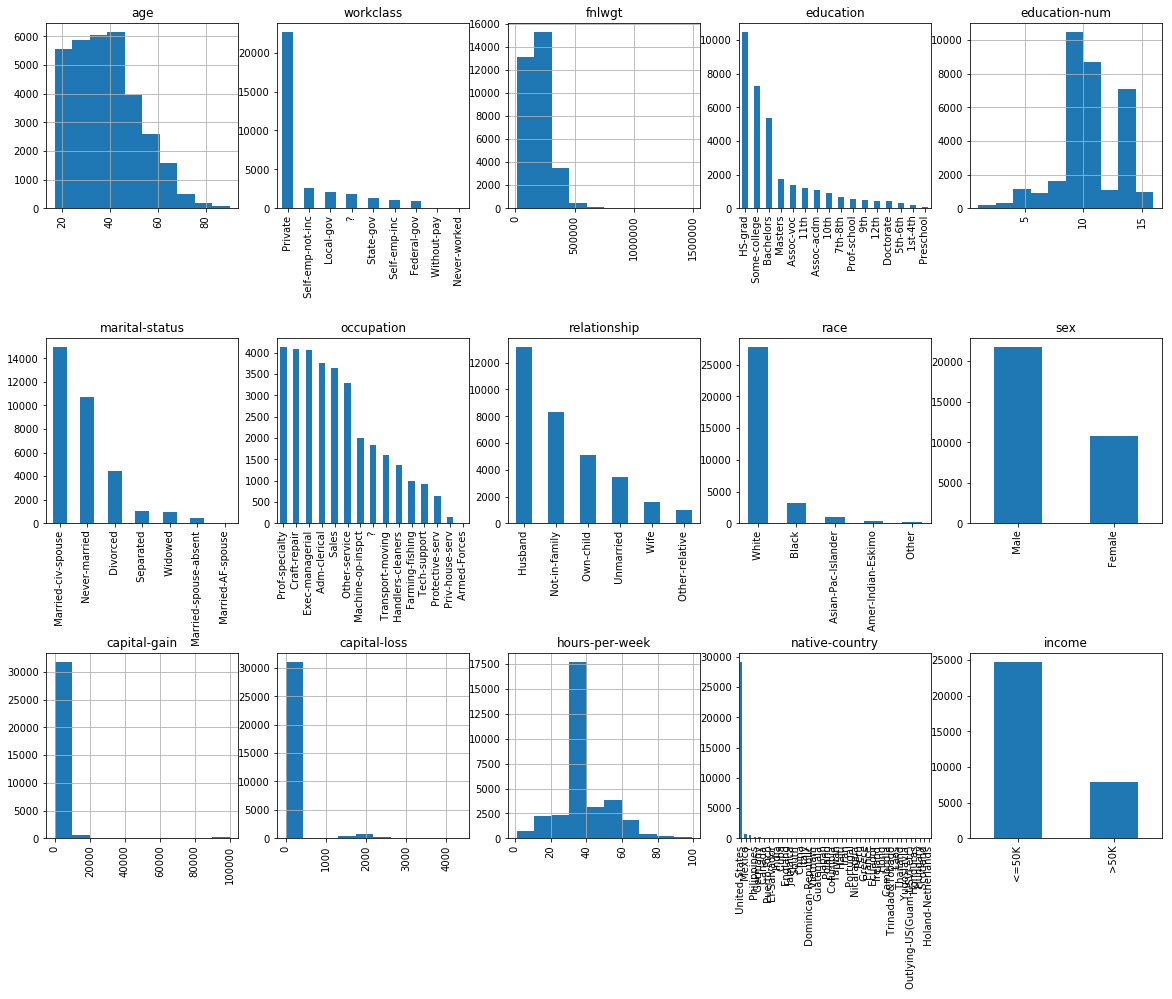

In [6]:
from math import ceil

fig = plt.figure(figsize=(20,15))
cols = 5
rows = ceil(float(original_train.shape[1]) / cols)
for i, column in enumerate(original_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if original_train.dtypes[column] == np.object:
        original_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        original_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

# Analysis:
1)Most people are white.

2)Most people are Male.

3)Most people are from United States with income <=50K and working in a private sectore
    
    
    
    

# Lets encode the Categorical features

In [7]:
from sklearn.preprocessing import LabelEncoder
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

In [8]:
#Encode data in test dataframe 

encoded_test, _ = number_encode_features(original_test)

# Lets us find the Corelation between the features

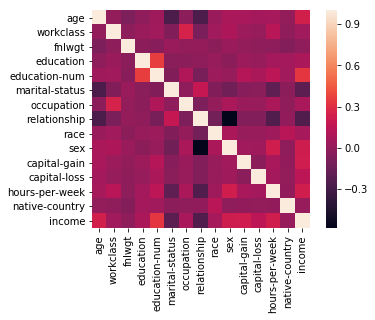

In [9]:
# Calculate the correlation and plot it
from sklearn.preprocessing import LabelEncoder
encoded_train, _ = number_encode_features(original_train)
sns.heatmap(encoded_train.corr(), square=True)
plt.show()

We see there is a high correlation between Education and Education-Num. They actually represent the same features, but encoded as strings and as numbers. We don’t need the string representation, so we can just delete this column. Note that it is a much better option to delete the Education column as the Education-Num has the important property that the values are ordered: the higher the number, the higher the education that person has.Other than that, the data is mostly OK with the exception of Sex and Relationship, which seems to be negatively correlated.

In [10]:
encoded_train.drop(['education'], axis=1, inplace=True)
encoded_test.drop(['education'], axis=1, inplace=True)

In [11]:
encoded_train.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,13,2,10,5,2,0,0,0,40,5,0


In [12]:
encoded_test.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,226802,7,4,7,3,2,1,0,0,40,38,0
1,38,4,89814,9,2,5,0,4,1,0,0,50,38,0
2,28,2,336951,12,2,11,0,4,1,0,0,40,38,1
3,44,4,160323,10,2,7,0,2,1,7688,0,40,38,1
4,18,0,103497,10,4,0,3,4,0,0,0,30,38,0


We can see that the data is all numeric before we build our base model

# Splitting the Independent and Dependent features

In [13]:
# train set
X_train = encoded_train.drop(columns=['income'], axis=1)
y_train = encoded_train['income']

# test set
X_test = encoded_test.drop(columns=['income'], axis=1)
y_test = encoded_test['income']

# Scaling down the features:

In [14]:
feature_scale_train= [feature for feature in X_train.columns]

In [15]:
feature_scale_test= [feature for feature in X_test.columns]

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
scaler=StandardScaler()

In [18]:
scaler.fit(X_train[feature_scale_train])

C:\Users\K T KUMAR\Anaconda33\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [19]:
X_train =pd.DataFrame(scaler.transform(X_train[feature_scale_train]),columns=feature_scale_train)

C:\Users\K T KUMAR\Anaconda33\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [20]:

X_test =pd.DataFrame(scaler.transform(X_test[feature_scale_test]),columns=feature_scale_test)

C:\Users\K T KUMAR\Anaconda33\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [21]:
X_train.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.030671,2.150579,-1.063611,1.134739,0.921634,-1.317809,-0.277805,0.393668,0.703071,0.148453,-0.21666,-0.035429,0.291569
1,0.837109,1.463736,-1.008707,1.134739,-0.406212,-0.608387,-0.900181,0.393668,0.703071,-0.145920,-0.21666,-2.222153,0.291569
2,-0.042642,0.090050,0.245079,-0.420060,-1.734058,-0.135438,-0.277805,0.393668,0.703071,-0.145920,-0.21666,-0.035429,0.291569
3,1.057047,0.090050,0.425801,-1.197459,-0.406212,-0.135438,-0.900181,-1.962621,0.703071,-0.145920,-0.21666,-0.035429,0.291569
4,-0.775768,0.090050,1.408176,1.134739,-0.406212,0.810458,2.211698,-1.962621,-1.422331,-0.145920,-0.21666,-0.035429,-4.054223


In [22]:
X_test.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,-0.995706,0.090050,0.350774,-1.197459,0.921634,0.101036,0.966947,-1.962621,0.703071,-0.145920,-0.21666,-0.035429,0.163751
1,-0.042642,0.090050,-0.947095,-0.420060,-0.406212,-0.371912,-0.900181,0.393668,0.703071,-0.145920,-0.21666,0.774468,0.163751
2,-0.775768,-1.283635,1.394362,0.746039,-0.406212,1.046932,-0.900181,0.393668,0.703071,-0.145920,-0.21666,-0.035429,0.163751
3,0.397233,0.090050,-0.279070,-0.031360,-0.406212,0.101036,-0.900181,-1.962621,0.703071,0.895083,-0.21666,-0.035429,0.163751
4,-1.508894,-2.657320,-0.817458,-0.031360,0.921634,-1.554283,0.966947,0.393668,-1.422331,-0.145920,-0.21666,-0.845327,0.163751


In [23]:
encoded_train.groupby('income').count()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
income,,,,,,,,,,,,,
0,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720
1,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841


# Check if Balanced or Imbalanced data

In [24]:
y_train[y_train==0].count()

24720

In [25]:
y_train[y_train==1].count()

7841

It is clearly an inbalanced dataset and metrics like F1 can be used 

# Base Model-Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [27]:

lrmodel = LogisticRegression()
lrmodel.fit(X_train, y_train)

C:\Users\K T KUMAR\Anaconda33\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:

predicted = lrmodel.predict(X_test)
predicted

array([0, 0, 0, ..., 1, 1, 1])

In [29]:
# evaluation metrics

print("F1 Score:", format(metrics.f1_score(y_test, predicted), '.2f'))

F1 Score: 0.55


Text(0.5,442.811,'Predicted value')

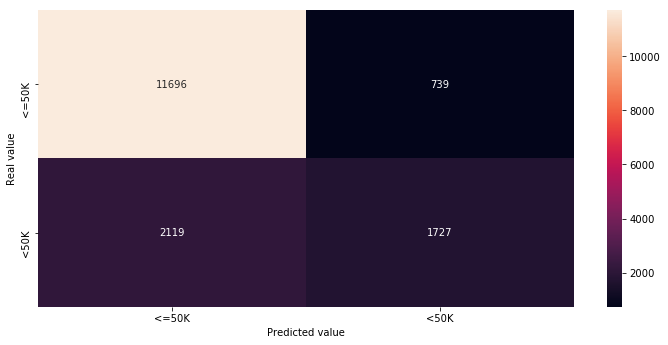

In [30]:
cm = metrics.confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['<=50K', '<50K'], yticklabels=['<=50K', '<50K'])
plt.ylabel("Real value")
plt.xlabel("Predicted value")

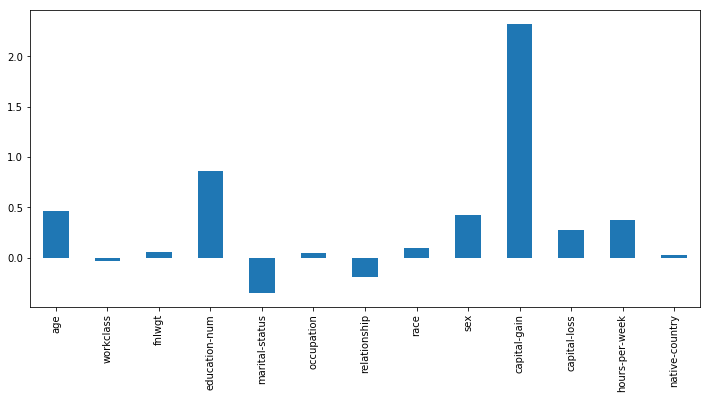

In [31]:
coefs = pd.Series(lrmodel.coef_[0], index=X_train.columns)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
coefs.plot(kind="bar")
plt.show()

We have got an F1 score of 55% and we see that the most important features that contributes to an income >50K is "Capital Gain",
"sex","age" and "education num".
Top Features that contribute to income<50K are marital status and relationship.

In [32]:
original_train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [33]:
encoded_train.head(10)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,13,2,10,5,2,0,0,0,40,5,0
5,37,4,284582,14,2,4,5,4,0,0,0,40,39,0
6,49,4,160187,5,3,8,1,2,0,0,0,16,23,0
7,52,6,209642,9,2,4,0,4,1,0,0,45,39,1
8,31,4,45781,14,4,10,1,4,0,14084,0,50,39,1
9,42,4,159449,13,2,4,0,4,1,5178,0,40,39,1


Analysis:
    1)workclass converted to numbers has no specific order like education num in which it might effect the income.
    Similarly marital-status,occupation,relationship,race,native-country.Let us resolve this by separating each categorical cla
    ssification into a separate column for the better to better understand the data.
    2)fnlwgt looks like soem randome numbers and can be dropped.
    


# Feature Engineering as per above analysis

In [34]:
# category columns that need to go through get_dummies as discussed in the above analysis
train_category = original_train[['workclass', 'marital-status', 'occupation', 'relationship', 
                                 'race', 'sex','native-country']]

In [35]:
# dummify the category column
train_category_dummy = pd.get_dummies(train_category, columns=['workclass', 'marital-status', 'occupation', 'relationship', 
                                 'race','sex', 'native-country'])

In [36]:
train_numeric=original_train[['age', 'education-num', 'capital-gain', 'capital-loss', 
                                 'hours-per-week']]

In [37]:
train_category_dummy.head()

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,marital-status_ Divorced,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
train_numeric.head()

,age,education-num,capital-gain,capital-loss,hours-per-week
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40
3,53,7,0,0,40
4,28,13,0,0,40


In [39]:
X_train = pd.concat([train_numeric,train_category_dummy], axis=1, sort=False)

In [40]:
X_train.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,13,0,0,13,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,9,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,53,7,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28,13,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#perform the feature engineering operation on test data

In [41]:
# category columns that need to go through get_dummies as discussed in the above analysis
test_category = original_test[['workclass', 'marital-status', 'occupation', 'relationship', 
                                 'race', 'sex','native-country']]

In [42]:
# dummify the category column
test_category_dummy = pd.get_dummies(test_category, columns=['workclass', 'marital-status', 'occupation', 'relationship', 
                                 'race','sex', 'native-country'])

In [43]:
test_numeric=original_test[['age', 'education-num', 'capital-gain', 'capital-loss', 
                                 'hours-per-week']]

In [44]:
X_test = pd.concat([test_numeric,test_category_dummy], axis=1, sort=False)

In [45]:
X_test.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,25,7,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,38,9,0,0,50,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,28,12,0,0,40,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,44,10,7688,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,18,10,0,0,30,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [46]:
# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( X_test.columns )

In [47]:
missing_cols

{'native-country_ Holand-Netherlands'}

Analyis:
    Holand Netherlands country is available in the train data and not in test data.This is leading to mismatch in the number of coluns in train and test
    1)one way is to crete a new column in test data with Netherlands and native coutry with value as zero
    2)second way is drop that specific row in train data where we have Netherlands.
    
Here we have only one row of this data which might not effects the model.so it can be droped

In [49]:

original_train[original_train['native-country']== 'Holand-Netherlands' ].shape

(0, 15)

In [51]:
X_train.drop(['native-country_ Holand-Netherlands'], axis=1, inplace=True)

In [52]:

lrmodel = LogisticRegression()
lrmodel.fit(X_train, y_train)

C:\Users\K T KUMAR\Anaconda33\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [53]:

predicted1 = lrmodel.predict(X_test)
predicted1

array([0, 0, 0, ..., 1, 0, 1])

In [56]:
print("F1 Score:", format(metrics.f1_score(y_test, predicted1), '.2f'))

F1 Score: 0.66


We can find a good improvement in our prediction rate in our base model using Logistic Regression.


# Feature Selection

In [81]:

feat_labels = ['workclass', 'marital-status', 'occupation', 'relationship', 'race',
               'sex', 'native-country', 'age', 'capital-gain', 'capital-loss',
               'education-num', 'fnlwgt', 'hours-per-week']

In [82]:

from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(lrmodel, threshold=0.05)
sfm.fit(X_train, y_train)

print ("Important features:\n")

for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

C:\Users\K T KUMAR\Anaconda33\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Important features:

marital-status
sex
native-country
age
capital-loss
education-num
fnlwgt
hours-per-week


IndexError: list index out of range

We can build a model with only important features and check our model perforance

In [83]:

X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [84]:
lrmodel_important = lrmodel
lrmodel_important.fit(X_important_train, y_train)

C:\Users\K T KUMAR\Anaconda33\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [85]:
predicted2= lrmodel_important.predict(X_important_test)
predicted2


array([0, 0, 1, ..., 1, 0, 1])

In [86]:
print("F1 Score:", format(metrics.f1_score(y_test, predicted2), '.2f'))

F1 Score: 0.60


# XGBoost

In [57]:
import xgboost
classifier=xgboost.XGBClassifier()

In [58]:
classifier.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [59]:
y_pred=classifier.predict(X_test)

In [60]:
print("F1 Score:", format(metrics.f1_score(y_test, y_pred), '.2f'))

F1 Score: 0.68


We find a slight improovement in our prediction rate.Now let us optimize the model for better results

In [68]:
from sklearn.model_selection import RandomizedSearchCV

In [69]:
#number f trees in random forest
n_estimators=[int(x) for x in np.linspace(start=100 ,stop=1200,num=12)]


#various learning rate parameters
learning_rate=['0.04','0.2','0.3','0.5','0.6','0.7']


#maximum  number of levels in tree
max_depth=[int(x) for x in np.linspace(5,30,num=6)]


#subsample parameter values
subsample=[0.8,0.7,0.5]

#minimum child weight parameters
min_child_parameters=[3,4,5,6,7]

In [70]:
random_grid={'n_estimators':n_estimators,
            'learning_rate':learning_rate,
            'max_depth':max_depth,
            'subsample':subsample,
            'min_child_parameters':min_child_parameters,
           }


print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'learning_rate': ['0.04', '0.2', '0.3', '0.5', '0.6', '0.7'], 'max_depth': [5, 10, 15, 20, 25, 30], 'subsample': [0.8, 0.7, 0.5], 'min_child_parameters': [3, 4, 5, 6, 7]}


In [71]:
# Set up the random search with 4-fold cross validation

random_cv=RandomizedSearchCV(estimator=classifier,param_distributions=random_grid,cv=5,n_iter=25,
                         n_jobs=3,verbose=5)

In [72]:
random_cv.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 50.6min
[Parallel(n_jobs=3)]: Done 125 out of 125 | elapsed: 103.2min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=25, n_jobs=3,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'learning_rate': ['0.04', '0.2', '0.3', '0.5', '0.6', '0.7'], 'max_depth': [5, 10, 15, 20, 25, 30], 'subsample': [0.8, 0.7, 0.5], 'min_child_parameters': [3, 4, 5, 6, 7]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=5)

In [73]:
random_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       learning_rate='0.04', max_delta_step=0, max_depth=5,
       min_child_parameters=3, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.5, verbosity=1)

In [74]:
classifier=xgboost.XGBClassifier(base_score=0.25, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate='0.04', max_delta_step=0,
             max_depth=10, min_child_parameters=3, min_child_weight=1,
             missing=None, n_estimators=400, n_jobs=1, nthread=None,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None, subsample=0.8,
             verbosity=1)

In [76]:
classifier.fit(X_train,y_train)

[00:03:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBClassifier(base_score=0.25, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       learning_rate='0.04', max_delta_step=0, max_depth=10,
       min_child_parameters=3, min_child_weight=1, missing=None,
       n_estimators=400, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.8, verbosity=1)

In [77]:
y_pred1=classifier.predict(X_test)

In [78]:
print("F1 Score:", format(metrics.f1_score(y_test, y_pred1), '.2f'))

F1 Score: 0.70


Problem 1: 
Prediction task is to determine whether a person makes over 50K a year. 

Prediction with 70% F1 score has been acheived which is a pretty decent model using XGBoost with Hyperparameter optimization


Problem 2: 
Which factors are important 

SelectForModel has been used for featureSelection.However feature importance has not played any keyrole in prediction task of whther 
a person can make over 50K a year

Problem 3: 
Which algorithms are best for this dataset

XGBoost with Hyperparameter tuning has been the best model so far with 70% F1 score